# Exploring data

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

from util.DicomReader import DicomReader
from util.segmentation import *


In [2]:
data_dir = 'toy_data'
train_img_dir = f"{data_dir}/train_images"
test_img_dir = f"{data_dir}/test_images"

train_csv = f"{data_dir}/train.csv"
test_csv = f"{data_dir}/test.csv"

In [3]:
train_df = pd.read_csv(train_csv)

# Superpixel segmentation

resizing image from: (2560, 3328) to (640,832)


<AxesSubplot: >

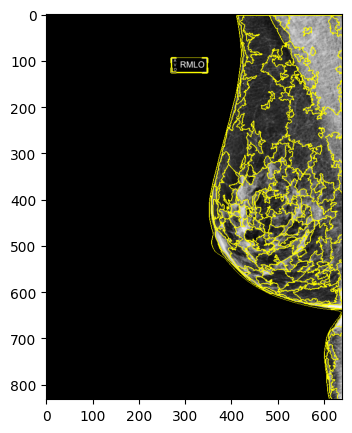

In [4]:
from matplotlib.lines import Line2D
import cv2
SCALE_RATIO = .25
GRAPH_DATA_DIRNAME = 'graphs'

    # create the directory to hold graph data
if not os.path.isdir(GRAPH_DATA_DIRNAME):
    os.mkdir(GRAPH_DATA_DIRNAME)

image_reader = DicomReader("toy_data/train.csv")
patient_id, image_id, img, cancer = image_reader.extract_img_and_meta("toy_data/train_images/24947/1231101161.dcm", plot_img=False)
# 1564214908
width = int(img.shape[1] * SCALE_RATIO)
height = int(img.shape[0] * SCALE_RATIO)
dim = (width, height)
print(f"resizing image from: ({img.shape[1]}, {img.shape[0]}) to ({width},{height})")
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
segments = segment_img(img)

visualize_segments(img, segments)

#segments_ids = np.unique(segments)

# centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

# vs_right = np.vstack([segments[:,:-1].ravel(), segments[:,1:].ravel()])
# vs_below = np.vstack([segments[:-1,:].ravel(), segments[1:,:].ravel()])
# bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(111)
# # plt.imshow(img, cmap=plt.cm.gray)
# plt.imshow(mark_boundaries(img, segments)) 
# plt.scatter(centers[:,1],centers[:,0], c='m')

# for i in range(bneighbors.shape[1]):
#     y0,x0 = centers[bneighbors[0,i]]
#     y1,x1 = centers[bneighbors[1,i]]

#     l = Line2D([x0,x1],[y0,y1], alpha=0.3, c='m')
#     ax.add_line(l)

# # plt.imshow(mark_boundaries(np.array(img), segments))

# Featurizing superpixels

<AxesSubplot: >

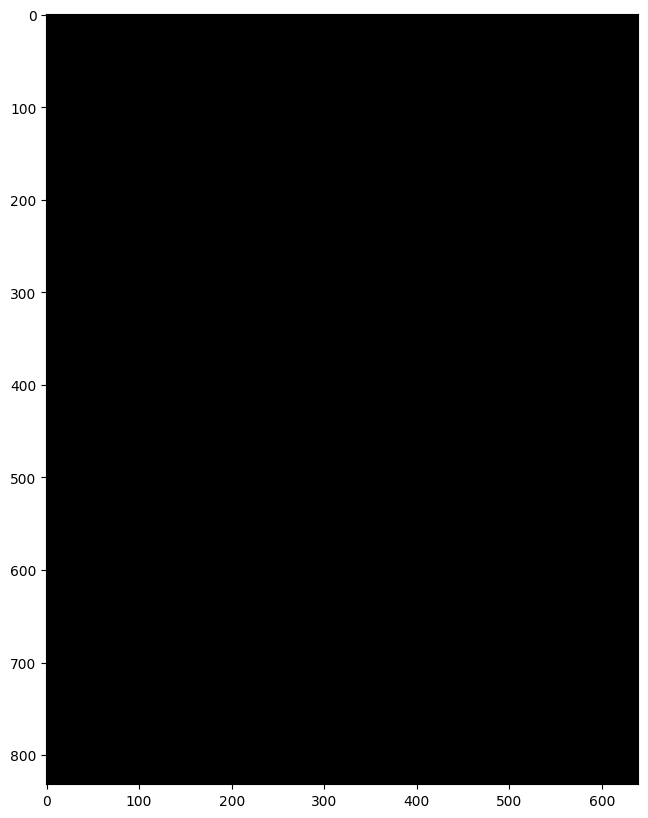

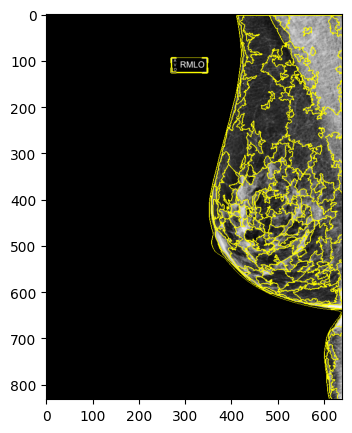

In [21]:
from util.featurize import extract_features
import scipy.stats
from matplotlib import pyplot as plt

def get_segment(segments, i):
    # return the values from the superpixel, fill rest with 0
    return np.where((segments==i), img, 0)

def get_segment_values(segments, i):
    # get the segmented superpixel
    segment = get_segment(segments, i)
    # get non-zero pixels
    values = segment.ravel()[segment.ravel() > 0]
    
    return values
    
def featurize_segment(segments, i):
    
    vals = get_segment_values(segments, i)
    
    features = {'segment_id': i,
                'std': np.std(vals), 
                'mean': np.mean(vals),
                'entropy': scipy.stats.entropy(vals)}
    return features

    
fig = plt.figure(figsize=(10,10))

segment_i = 0
plt.imshow(get_segment(segments, segment_i), cmap=plt.cm.gray)
visualize_segments(img, segments)


In [9]:
from util.featurize import extract_features

features = extract_features(img, segments, True)

number of features: 186
number of segments: 187


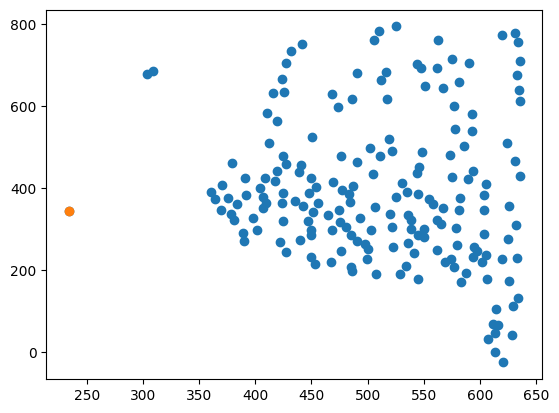

In [19]:
feature_center_x = []
feature_center_y = []
for i, feature_set in enumerate(features):
    feature_center_x.append(feature_set['center_x'])
    feature_center_y.append(feature_set['center_y'])

segment_center_x = []
segment_center_y = []
segments_ids = np.unique(segments)
centers = np.array([np.mean(np.nonzero(segments == i), axis=1) for i in segments_ids])
for a_center in centers:
    segment_center_x.append(a_center[0])
    segment_center_y.append(a_center[1])
pixel_index = 0

plt.scatter(segment_center_y,np.max(feature_center_x) - segment_center_x) # plot of segmentation centers
plt.scatter(feature_center_y[pixel_index],np.max(feature_center_x) - feature_center_x[pixel_index]) # plot of centers after featurization
print("number of features: " + str(np.size(features)))
print("number of segments: " + str(np.size(segments_ids)))

In [ ]:
print("feature last: " + str(feature_center_x[np.size(features)-1]) + " " + str(feature_center_x[np.size(features)-1]))
print("segemnt last: " + str(segment_center_x[np.size(features)]) + " " + str(segment_center_x[np.size(features)]))
# np.max(segment_center_x)
# np.max(feature_center_x) # w/o  last value
# plt.imshow(get_segment(features, segment_i), cmap=plt.cm.gray)


# Computing features and creating a graph

In [ ]:
import networkx as nx
G = nx.Graph()

# add nodes
nodes = []
centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])
for i in range(1, len(np.unique(segments))):
    
    # TODO: remove the background segment
    
    feats = featurize_segment(segments, i)
    feats['node_x'] = centers[i][0]
    feats['node_y'] = centers[i][1]
    
    node_id = feats['segment_id']
    del feats['segment_id']
    
    nodes.append((node_id, feats))
    
G.add_nodes_from(nodes)
        
# add edges (connect every node to every), TODO: weights based on similarity
from itertools import product

G.add_edges_from((a,b) for a,b in product(range(len(G.nodes)), range(len(G.nodes))) if a != b)